In [35]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
%matplotlib inline

/usr/lib/python3.10/site-packages
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from quilt.builder import NeuronCatalogue, SpikingNetwork

catalogue = NeuronCatalogue.from_yaml("tests/basal_ganglia_neurons.yaml")

Loaded model for neuron 'D1_neuron'

Loaded model for neuron 'D2_neuron'

Loaded model for neuron 'FSN_neuron'

Loaded model for neuron 'GPeTA_neuron'

Loaded model for neuron 'GPeTI_neuron'

Loaded model for neuron 'STN_neuron'

Loaded model for neuron 'SNR_neuron'

In [3]:
sn = SpikingNetwork.from_yaml("tests/basal_ganglia_network.yaml", catalogue)
sn.rescale_populations(1.0)
sn.rescale_connectivity(1)
sn.rescale_weights(1)
sn.rescale_delays(1)
sn.build()

Output()

In [4]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)

## Input/Output

In [5]:
pop_state_monitorized = "FSN"
for population in sn.populations.values():
    population.monitorize_spikes()
sn.populations[pop_state_monitorized].monitorize_states()

In [6]:
poisson_rescale = 0.5
poisson_inputs = dict(STN   = [500, 0.25],
                      GPeTA = [170, 0.15],
                      GPeTI = [1530, 0.25 ],
                      FSN   = [944.4, 0.5],
                      SNR   = [600, 0.55]
                    )

for pi in poisson_inputs.values():
    pi[1] *= poisson_rescale
    
for pop in poisson_inputs:
    sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])

sn.populations["D1"].add_poisson_spike_injector(poisson_rescale * 1120, 0.45)
sn.populations["D2"].add_poisson_spike_injector(poisson_rescale * 972.927, 0.45) 

In [7]:
sn.run(dt=0.1, time=1000)

Running network consisting of 14622 neurons for 10000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 32 s	(3.2452 ms/step)
	Gathering time avg: 42.1943 us/step
	Inject time avg: 59.5861 us/step


In [8]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data()['spikes']

states = sn.populations[pop_state_monitorized].get_data()['states']

Mean firing rate D1:	0.0 Hz
Mean firing rate D2:	0.0 Hz
Mean firing rate FSN:	0.0 Hz
Mean firing rate GPeTI:	66.6 Hz
Mean firing rate GPeTA:	9.7 Hz
Mean firing rate STN:	10.9 Hz
Mean firing rate SNR:	0.0 Hz


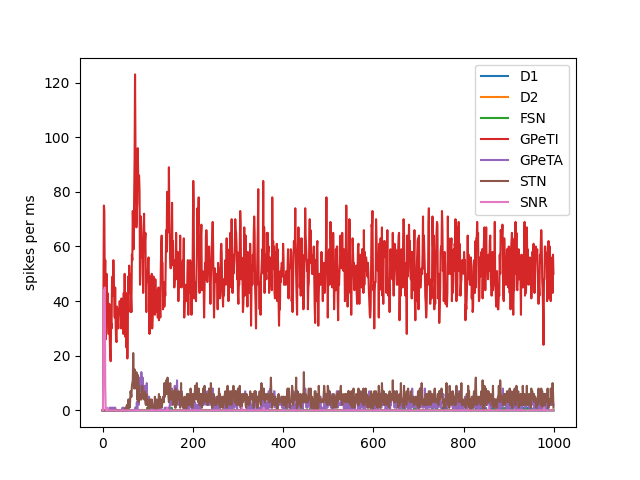

In [22]:
fig, ax = plt.subplots()
timesteps_per_bin = 10
binned_signals = dict()

for pop in spikes.keys():
    binned_signals[pop] = np.sum( 
                            spikes[pop][:(len(spikes[pop])//timesteps_per_bin)*timesteps_per_bin].reshape(-1, timesteps_per_bin),
                            axis=1).squeeze()
    
    mfr = np.mean(binned_signals[pop][200:]) * 1e3 / sn.populations[pop].n_neurons
    print(f"Mean firing rate {pop}:\t{mfr:.1f} Hz")
    plt.plot(binned_signals[pop], label=pop)
             
plt.legend()
plt.ylabel("spikes per ms");


D1 2.0


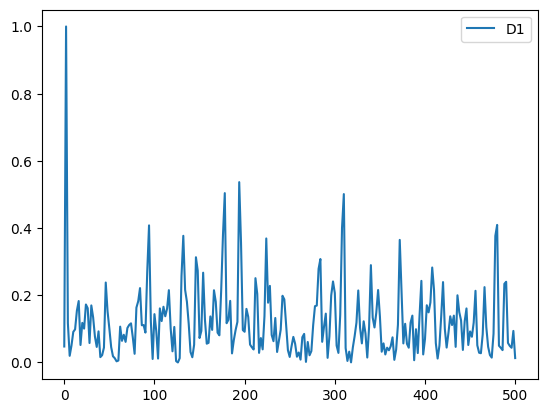

D2 0.0


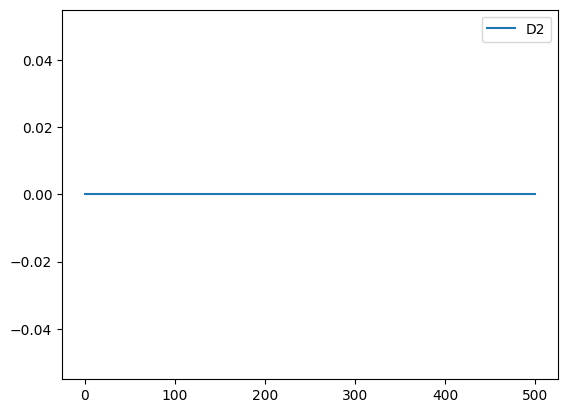

FSN 456.0


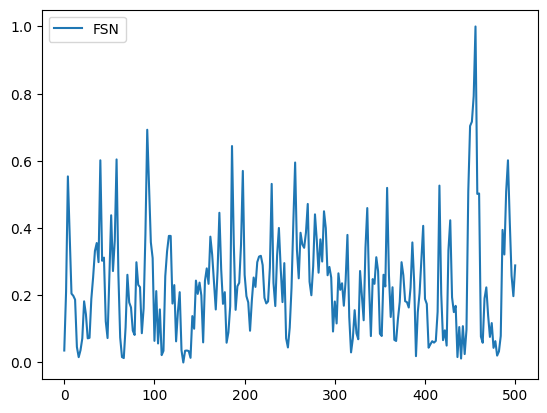

GPeTI 98.0


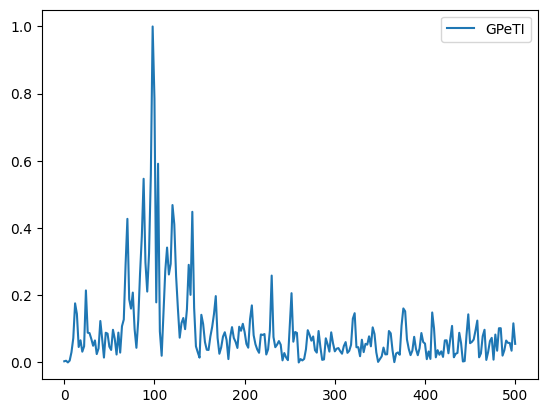

GPeTA 14.0


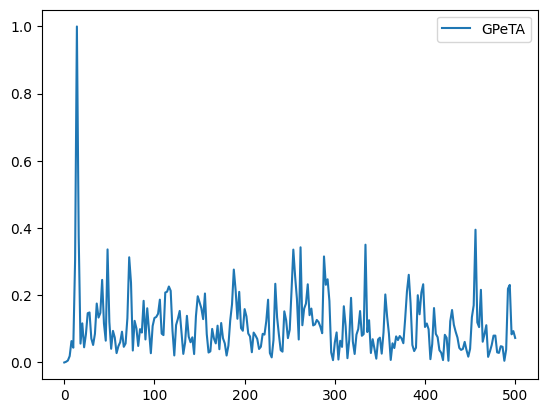

STN 450.0


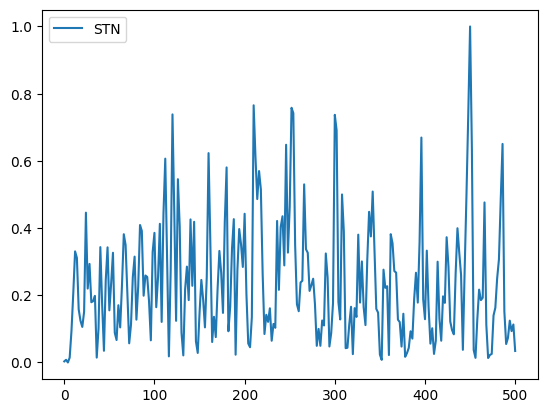

SNR 2.0


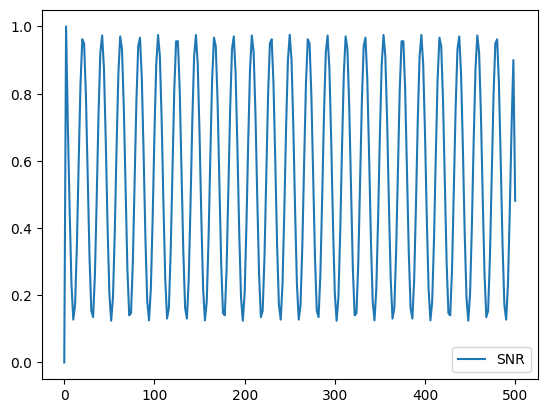

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 150.0)

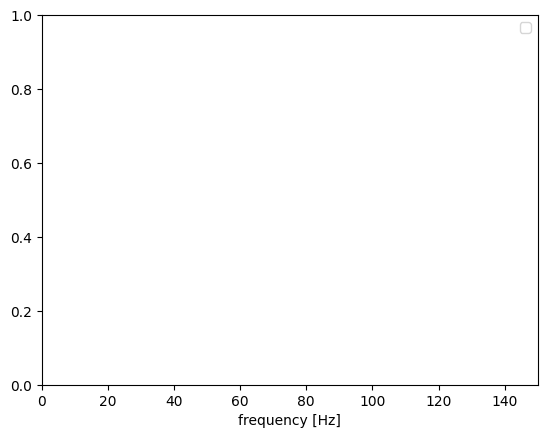

In [72]:
from numpy.fft import fft, fftfreq
from scipy.signal import welch
from sklearn.preprocessing import MinMaxScaler
from neurodsp.filt import filter_signal

fig, ax = plt.subplots()
scaler = MinMaxScaler()

burn_in = 200

for pop in sn.populations.keys():
    signal = binned_signals[pop][burn_in:]
    # signal = butter_bandpass_filter(signal, 0.2, 80, 1000, order=4)
    # fig, ax = plt.subplots()
    f, PSD = welch(signal, 
                   1000, 
                   nperseg=500, 
                   noverlap=250,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    # print(PSD)
    plt.plot(f, scaler.fit_transform(PSD[:, None]).squeeze(), label=pop)
    # plt.plot(f, PSD, label=pop)
    print(pop, f[np.argmax(PSD)])
    plt.legend()
    plt.show()
    # break
# plt.xlim([0,50]);
plt.legend();
plt.xlabel("frequency [Hz]")
plt.xlim(0,150)

Text(0.5, 1.0, 'FSNV')

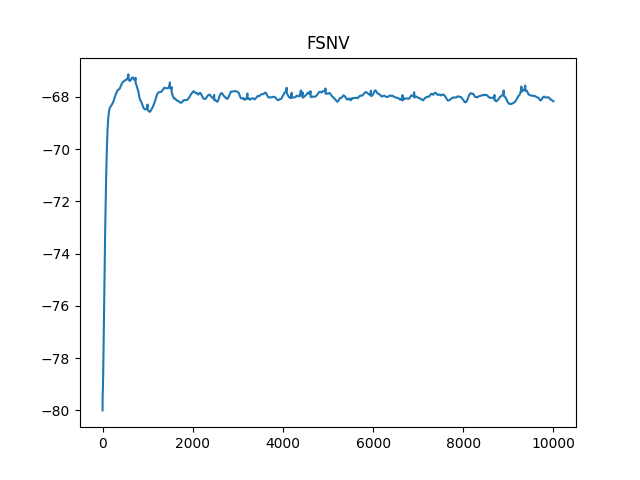

In [21]:
fig,ax = plt.subplots()
plt.plot(np.mean(states[:, :, 0], axis=1))
plt.title(pop_state_monitorized+"V")
# plt.xlim(0,1000)

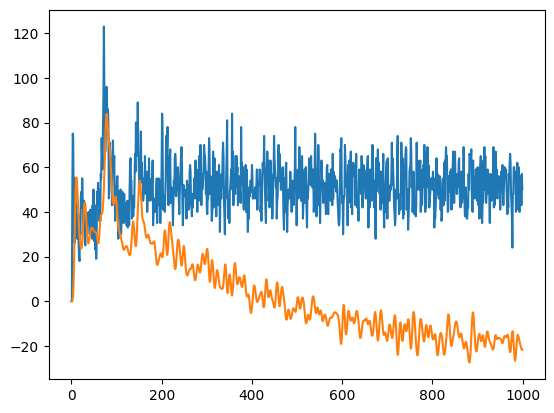

In [69]:
from scipy.signal import butter, lfilter


from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    # low = lowcut / nyquist
    # high = highcut / nyquist
    low = lowcut
    high = highcut
    b, a = butter(order, [low, high], fs=fs, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y
    
pop = "GPeTI"

plt.plot(binned_signals[pop])
plt.plot(butter_bandpass_filter(binned_signals[pop], 0.2, 80, 1000, order=4))
# plt.ylim(-11250,11250)